# Mode choice prediction for non-car owning households in the USA
**Decision-aid methodologies in transportation, EPFL Spring 2021**

Florent Zolliker, Gaelle Abi Younes, Luca Bataillard

## Step 1: Data pre-processing

In this step, we will process and adjust the dataset in order to facilitate our model training. We begin by importing the datasets and relevant libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 1
np.random.seed(SEED)

In [2]:
train_validate = pd.read_csv("nhts_train_validate_revised.csv", index_col="TRIPID")
test = pd.read_csv("nhts_test_revised.csv", index_col="TRIPID")

We now need to consider the features and their format in order to select the appropriate ones. 

We first notice a group of context columns, that are not relevant to model training:
* `TRIPID`: trip identifier, indexes the dataset but otherwise not relevant for training or grouped sampling.
* `HOUSEID`: household identifier, this is the topmost hiearchical group in the survey. This column should be used to perform grouped samping during cross-validation
* `PERSONID`: person identifier, this is another hiearchical group, but since `HOUSEID` is higher in the hiearchy, using it is not necessary.
* `TDTRPNUM`: trip numbering per person in the survey.

The target label is `TRAVELMODE`. This label is categorical, so we will encode the values using a simple numeric encoding. 

We also notice a `TRPTRANS` column that is very highly correllated with `TRAVELMODE` but does not feature in the `nhts_dictionary.csv` file provided with the project. After inspecting the NHTS documentation online, we suspect that the travel mode column was most likely generated from this column. We will thus discard the `TRPTRANS`column. Furthermore, negative responses in the `TRPTRANS` column resulted in `NaN` values in `TRAVELMODE`, that need to be filtered out.

Let us analyse the remaining columns. Missing values indicates that some values for that column are invalid in the dataset. In the case of categorical, this does not pose a big problem, since 

| Column name | Missing values | Categorical data | One-hot encoding | Scaling | Use feature? | Description | Comments |
| ---         | ---            | ---              | ---              | ---     | ---          | ---         | ---      |
| `STRTTIME`  |  -  |  -  |  -  | yes | yes | start time of trip | |
| `TRPMILES`  | yes |  -  |  -  | yes | yes | length of trip in miles ||
| `LOOP_TRIP` |  -  | yes | yes |  -  | yes | same origin and destination | binary variable, applying `mod 2` to this column can replace one-hot encoding |
| `TRIPPURP`  |  -  | yes | yes |  -  | yes | trip purpose ||
| `TRAVDAY`   |  -  | yes |  -  | yes | yes | weekday of travel ||
| `HOMEOWN`   | yes | yes | yes |  -  | yes | home ownership ||
| `HHSIZE`    |  -  |  -  |  -  | yes | yes | size of household ||
| `HHFAMINC`  | yes | yes |  -  | yes | yes | household income ||
| `HHSTATE`   |  -  | yes | yes |  -  |  ?  | household state of residency | could use either `HHSTATE` or `CENSUS_D` |
| `WRKCOUNT`  |  -  |  -  |  -  | yes | yes | number of workers in household ||
| `LIF_CYC`   |  -  |  -  |  -  | yes | yes | life cycle classification ||
| `URBAN`     |  -  | yes |  ?  |  ?  | yes | classification of urban area ||
| `URBANSIZE` |  -  | yes |  ?  |  ?  |  ?  | population size of urban area | redundant with `URBAN`, needs reordering or one-hot encoding |
| `CENSUS_D`  |  -  | yes | yes |  -  |  -  | census division (region) of household | could be redundant with `HHSTATE` |
| `HH_RACE`   | yes | yes | yes |  -  |  yes  | race of household | |
| `EDUC`      | yes | yes |  -  | yes |  yes  | educational attainment of household | |
| `WORKER`    | yes | yes | yes |  -  |  yes  | worker status | |
| `WHYTRP90`  | yes | yes | yes |  -  |  yes  | trip purpose with 1990 NPTS design | possible duplicate of `TRIPPURP`|
| `R_AGE_IMP` |  -  |  -  |  -  | yes |  yes  | age | |
| `R_SEX_IMP` |  -  | yes | yes |  -  |  yes  | gender | |
| `OBHUR`     | yes | yes |  -  |  -  |  yes  | urban/rural indicator at origin | |
| `DBHUR`     | yes | yes |  -  |  -  |  yes  | urban/rural indicator at destination | |
| `OBPPOPDN`  | yes | yes |  -  |  -  |   -   | population density at origin | already covered by `OBHUR` |
| `DBPPOPDN`  | yes | yes |  -  |  -  |   -   | population density at destination | already covered by `DBHUR` |














In [3]:
# Target column and topmost hiearchical sampling column
target = "TRAVELMODE"
group = "HOUSEID"

# Context columns (not used here) 
context_cols = [
    "TRIPID", "HOUSEID", "PERSONID", "TDTRPNUM"
]

# Columns used as features that do not need a specific encoding 
no_changes = [
    "STRTTIME", "TRPMILES", "TRAVDAY", "HHSIZE", "HHFAMINC", "WRKCOUNT", 
    "LIF_CYC", "URBAN", "EDUC", "R_AGE_IMP", "DBPPOPDN", "OBPPOPDN"
]

# Categorical columns that need one-hot encoding and the values they can take
one_hot_encodings = {
    "TRIPPURP": ["HBO", "HBSHOP", "HBSOCREC", "HBW", "NHB", -9],
    "HOMEOWN": [1, 2, 97, -8, -7],
    "HHSTATE": ["AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "IA", "ID", "IL", "IN", 
                   "KS","KY", "LA", "MA", "MD", "ME", "MI", "MN", "MO", "MS", "MT", "NC", "ND", "NE", "NH", "NJ","NM",
                    "NV","NY", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VA", "VT", "WA", "WI", 
                    "WV", "WY"],
    "CENSUS_D": [c for c in range(1, 10)],
    "HH_RACE": [1, 2, 3, 4, 5, 6, 97, -7, -8], 
    "WORKER": [1, 2, -9, -1],
    "WHYTRP90": [1, 2, 3, 4, 5, 6, 8, 10, 11, 99],
    "R_SEX_IMP": [1, 2],
}

# Columns that need some in-place transformation (such as numerical label encoding) 
hur_encoding = lambda x: ["-9", "R", "T", "C", "S", "U"].index(x)
label_encodings = {
    "LOOP_TRIP": lambda x: x % 2,
    "URBANSIZE": lambda x: (x % 6) + 1,
    "OBHUR": hur_encoding,
    "DBHUR": hur_encoding,
}

In [4]:
from sklearn.model_selection import GroupShuffleSplit

def train_validate_split(X, y, groups, train_size=0.8):
    """
    Splits a dataset into a training and validation set 
    using randomized group-based sampling
    Returns (X_train, y_train, X_validate, y_validate) 
    where X_train, y_train contain a `train_size` fraction of data
    """
    
    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=SEED)
    train_idx, validate_idx = gss.split(X, y, groups).__next__()
    return X.iloc[train_idx], y.iloc[train_idx], groups.iloc[train_idx],         \
           X.iloc[validate_idx], y.iloc[validate_idx], groups.iloc[validate_idx]

def one_hot_encode(df, col_cat_encodings):
    """
    Takes a NHTS pandas dataset and a dictionary mapping categorical columns to their
    possible values. 
    Returns a new dataset with all categorical column one-hot encoding. A column of zeroes
    is created for each value that appears in the list of possible values but not in actual data
    
    TODO: Check out https://www.algosome.com/articles/dummy-variable-trap-regression.html
    """
    
    labels = set([col + ":" + str(cat) for col, cats in col_cat_encodings.items() for cat in cats])
    original_columns = set(df.columns)
    new_columns = (original_columns | labels) - col_cat_encodings.keys()
    
    df_one_hot = pd.get_dummies(df, columns=col_cat_encodings.keys(), prefix_sep=":")
    df_full = df_one_hot.reindex(columns=new_columns, fill_value=0)
    
    return df_full

def process_dataset(df):
    """
    Takes a pandas dataset in the NHTS survey format, keeps only columns in `no_changes`,
    `one_hot_encodings` and `label_encodings`. One-hot encodes features in `one_hot_encodings`
    and generates numeric labels for columns in `label_encodings`
    Returns a new dataframe containing the transformed features.
    """
    
    columns = [*no_changes, *one_hot_encodings.keys(), *label_encodings.keys()]
    features = df[columns]
    
    X = one_hot_encode(features, one_hot_encodings)
    for column, encoding in label_encodings.items():
        X[column] = X[column].map(encoding)
        
    return X

def process_target(y, encoding):
    """
    Takes a target column and encodes it using the replacement dictionary provided
    Returns the encoded series
    """
    
    return y.replace(encoding)

In [5]:
# Remove NaN values from dataset
train_validate_no_nans = train_validate.dropna(axis="index")
test_no_nans = test.dropna(axis="index")

# Define deterministic label encoding for target label
target_encoding = {mode: index for index, mode in 
                   enumerate(sorted(train_validate_no_nans[target].unique().tolist()))}

# Encode columns, separate into features, target and groups
X_unsplit = process_dataset(train_validate_no_nans)
y_unsplit = process_target(train_validate_no_nans[target], target_encoding)
groups_unsplit = train_validate_no_nans[group]

# Separate 20% of sample into (X,y,groups)_val for validation and selection between models
X, y, groups, X_val, y_val, groups_val = train_validate_split(X_unsplit, y_unsplit, groups_unsplit)
X_test = process_dataset(test_no_nans)

An additional step to our algorithm is to apply scaling to our values, which is needed with distance-based models such as logistic classifiers and k-nearest neighbours.

For indicator variables, no scaling is necessary. For other values, we can apply min-max or standard scaling. Standard scaling should be used when data is supposed to be normally distributed. Given that there are very few features where that assumption can be confidently made, we will apply min-max scaling to all scalable columns.

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# List of columns that need scaling (all except the one-hot encoded columns)
scaled_columns = no_changes + list(label_encodings.keys())

def scale(X, *X_tests, scaler=MinMaxScaler(), columns=scaled_columns):
    """
    Takes a training dataset and an array of test datasets and scales specified `columns` using `scaler`
    The scaling is fitted on the training dataset and is applied to all datasets in the array
    Returns scaled (X, *X_tests)
    """
    
    X_sc, X_test_scs = X.copy(), [X_test.copy() for X_test in X_tests]
    
    scaler.fit(X_sc[scaled_columns])
    
    X_sc[scaled_columns] = scaler.transform(X_sc[scaled_columns])
    for X_test_sc in X_test_scs:
        X_test_sc[scaled_columns] = scaler.transform(X_test_sc[scaled_columns])
    
    return X_sc, *X_test_scs

# Scale using a Min-Max scaler and a Standard scaler
X_sc, X_val_sc, X_test_sc, X_unsplit_sc = scale(X, X_val, X_test, X_unsplit, scaler=MinMaxScaler())
X_std_sc, X_val_std_sc, X_test_std_sc, X_unsplit_std_sc = scale(X, X_val, X_test, X_unsplit_sc, scaler=StandardScaler())

## Step 2: Hyperparameter search and model training

This project makes use of several heavy objects that take a significant amount of time to create. To reduce recomputation time when running the notebook again, we define a memoization utility function.

In [7]:
from functools import wraps
import os, joblib

def memoize(filename, func, *fargs, **fkwargs):
    """
    On first call, calls `func` with arguments `fargs` and `fkwargs`. Saves returned object to memo/`filename`.joblib.
    Subsequent calls retreive object from file. Returns saved object.
    """
    
    full_filename = "memo/" + filename + ".joblib"
    
    @wraps(func)
    def wrapper():
        if not os.path.isfile(full_filename):
            obj = func(*fargs, **fkwargs)
            joblib.dump(obj, full_filename)
            return obj
        else:
            return joblib.load(full_filename)
    
    return wrapper


We then define a generalised way of performing hyperparameter tuning. This will be applied to all models tried out throughout this notebook. We create a decorated memoized version of the same function.

In [9]:
from sklearn.model_selection import RandomizedSearchCV, GroupKFold

def hyperparam_search(classifier, params, X=X, y=y, groups=groups, verbose=20, fit_params={}):
    """
    Takes a classifier, a dictionary of hyperparameter distributions and an (X,y,groups) dataset
    and returns a SearchCV object. The returned object is also saved to `filename` if it not none.
    Defaults to using non-scaled (X,y,groups).
    """
    
    gkf = GroupKFold(n_splits=5)
    search = RandomizedSearchCV(classifier, params,
                                scoring="neg_log_loss",
                                cv=gkf, 
                                n_jobs=-1, 
                                verbose=verbose, 
                                random_state=SEED)

    search.fit(X, y.squeeze(), groups=groups, **fit_params)
    
    return search

@wraps(hyperparam_search)
def m_hyperparam_search(filename, *fargs, **fkwargs):
    """Memoized hyperparameter search"""
    
    return memoize(filename, hyperparam_search, *fargs, **fkwargs)()

We will perform a hyperparameter search on multiple models to find the best performing version of each model. This will yield a `RandomizedSearchCV` object for each model, that will be used during model evaluation.

### Gradient Boosting

The first model we will consider is XGBoost. This model does not require feature scaling, so we will use the unscaled X dataset. We decide to optimize over the number of estimators, the maximum tree depth, the learning rate and the L2 regularization factor. All distributions range around their default value.

In [10]:
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

xgb_params = {
    "n_estimators": randint(20, 1000),
    "max_depth": randint(1, 8),
    "learning_rate": uniform(0.1, 1),
    "reg_lambda": uniform(0.1, 2), 
}


xgb = XGBClassifier(objective="multi:softprob",
                    num_class=len(y.squeeze().unique()),
                    random_state=SEED,
                    use_label_encoder=False,
                    eval_metric='mlogloss')


xgbsearch = m_hyperparam_search("xgb_search", xgb, xgb_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  4

In [11]:
print(f"Found best parameters for XGBoost, mean CV score={xgbsearch.best_score_}")
print(f"Using parameters:")
for param, value in xgbsearch.best_params_.items():
    print(f"\t{param}={value}")

best_xgb = memoize("best_xbg", lambda: xgbsearch.best_estimator_.fit(X, y))()

Found best parameters for XGBoost, mean CV score=-1.0758287637244723
Using parameters:
	learning_rate=0.40233257263183975
	max_depth=1
	n_estimators=164
	reg_lambda=0.8931614545920522


### Logistic regression

The next model we will try will be logistic regression. We chose to optimise over the type of regularization, the regularization coefficient and the class weigthing mode (adjust weights inversely proportional to class label frequency). We will try using a standard-scaled and a min-max-scaled dataset.

In [12]:
from sklearn.linear_model import LogisticRegression

log_params = {
    "penalty": ["l1", "l2"],
    "C": uniform(0.1, 3),
    "class_weight": ["balanced", None],
}

logreg = LogisticRegression(solver='saga', 
                            multi_class='multinomial', 
                            random_state=SEED,
                            max_iter=500)

logsearch = m_hyperparam_search("logreg_search", logreg, log_params, X=X_sc)
logstdsearch = m_hyperparam_search("logreg_search_stdscale", logreg, log_params, X=X_std_sc)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  2

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.9min
[Paralle

In [13]:
print(f"Found best parameters for LinearRegression with MinMaxScaling, mean CV score={logsearch.best_score_}")
print(f"Using parameters:")
for param, value in logsearch.best_params_.items():
    print(f"\t{param}={value}")
    
print(f"\nFound best parameters for LinearRegression with StandardScaling, mean CV score={logstdsearch.best_score_}")
print(f"Using parameters:")
for param, value in logstdsearch.best_params_.items():
    print(f"\t{param}={value}")
    
best_logreg = memoize("best_logreg", lambda: logsearch.best_estimator_.fit(X, y))()
best_logreg_std = memoize("best_logregstd", lambda: logstdsearch.best_estimator_.fit(X, y))()

Found best parameters for LinearRegression with MinMaxScaling, mean CV score=-1.3678499647359832
Using parameters:
	C=0.6587806341330127
	class_weight=None
	penalty=l1

Found best parameters for LinearRegression with StandardScaling, mean CV score=-1.2269586465697686
Using parameters:
	C=0.6587806341330127
	class_weight=None
	penalty=l1


C:\Users\Luca\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Luca\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


### Random forests

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    "n_estimators": randint(100, 1000),
    "criterion": ["gini", "entropy"],
    "max_depth": randint(1, 20),
    "max_features": uniform(0.05, 1),
    "min_samples_leaf": randint(1, 30),
}

rf = RandomForestClassifier(random_state=SEED, 
                            n_jobs=-1)

rfsearch = m_hyperparam_search("rf_search", rf, rf_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.1min
[Paralle

In [15]:
print(f"Found best parameters for RandomForestClassifier, mean CV score={rfsearch.best_score_}")
print(f"Using parameters:")
for param, value in rfsearch.best_params_.items():
    print(f"\t{param}={value}")

best_rf = memoize("best_rf", lambda: rfsearch.best_estimator_.fit(X, y))()

Found best parameters for RandomForestClassifier, mean CV score=-1.091339650442333
Using parameters:
	criterion=gini
	max_depth=14
	max_features=0.32304997421674736
	min_samples_leaf=11
	n_estimators=733


### K-Nearest Neighbours

### Deep Neural Networks

## Step 3: Model evaluation and analysis

In [31]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.base import clone

def evaluate_model(name, model, searchcv, X_val=X_val, y_val=y_val):
    """
    Takes an already fitted model and evaluates its performance on the validation dataset.
    """
    
    classes = target_encoding.keys()
    
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)
    
    ll = log_loss(y_val, y_pred_proba)
    acc = accuracy_score(y_val, y_pred)
    
    fit_model_clone = memoize(f"feature-model-copy-{name.lower()}", lambda: clone(model).fit(X, y))()
    permutator = memoize(f"feature-imp-{name.lower()}", permutation_importance,
                         fit_model_clone, X_val, y_val, n_repeats=5, n_jobs=-1,
                         scoring="neg_log_loss", random_state=SEED)()
    
    permutation_importances = pd.Series(permutator['importances_mean'], index=X_val.columns.values)

    
    print("============== Basic metrics ================")
    print(f"Model {name} with parameters:")
    for param, value in searchcv.best_params_.items():
        print(f"\t{param}={value}")
    print(f"Evaluated on validation dataset got scores of ")
    print(f"\tcross-entropy loss: {ll}")
    print(f"\t          accuracy: {acc}")
    
    print("============== Confusion matrix ==============")
    fig, ax = plt.subplots(figsize=(8,6))
    plot_confusion_matrix(model, X_val, y_val, display_labels=classes, 
                          values_format='d', cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f'Confusion matrix for {name}')
    plt.show()
    
    print("============== Feature importance ============")    
    fig, ax = plt.subplots(figsize=(20, 7))
    permutation_importances.plot.bar(yerr=permutator['importances_std'], ax=ax)
    ax.set_title("Feature importances (using permutation approach)")
    ax.set_ylabel("Mean decrease in entropy")
    fig.tight_layout()   
    plt.show()

============== Basic metrics ================
Model RandomForestClassifier with parameters:
	criterion=gini
	max_depth=14
	max_features=0.32304997421674736
	min_samples_leaf=11
	n_estimators=733
Evaluated on validation dataset got scores of 
	cross-entropy loss: 1.064918881727214
	          accuracy: 0.649812734082397
============== Confusion matrix ==============


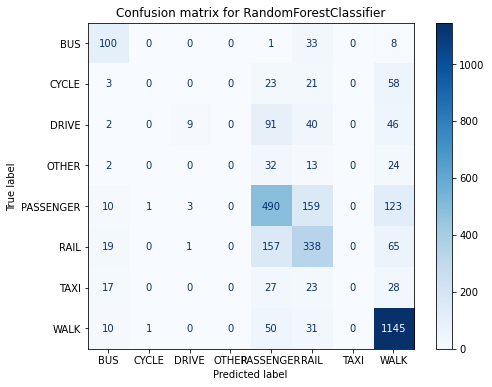

============== Feature importance ============


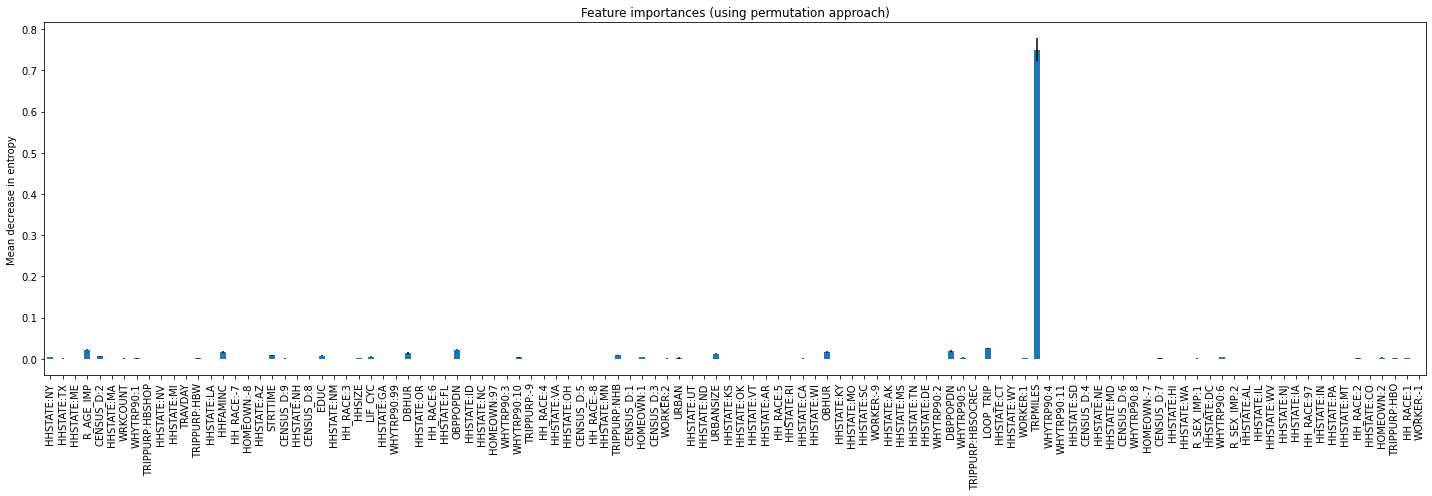

In [32]:
evaluate_model("RandomForestClassifier", best_rf, rfsearch)

============== Basic metrics ================
Model XGBoost with parameters:
	learning_rate=0.40233257263183975
	max_depth=1
	n_estimators=164
	reg_lambda=0.8931614545920522
Evaluated on validation dataset got scores of 
	cross-entropy loss: 1.0535772122947697
	          accuracy: 0.6410736579275905
============== Confusion matrix ==============


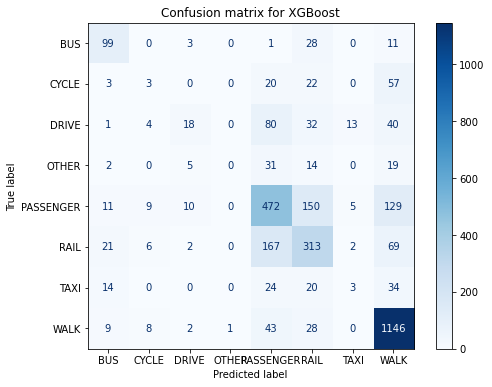

============== Feature importance ============


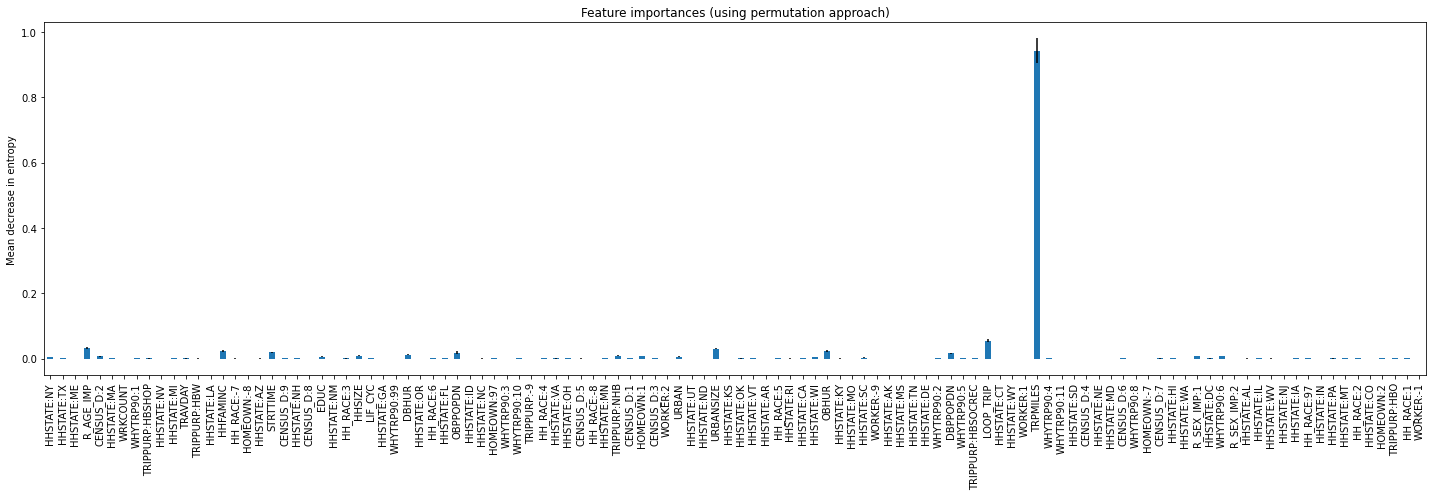

In [33]:
evaluate_model("XGBoost", best_xgb, xgbsearch)

============== Basic metrics ================
Model LogisticRegression (MinMax) with parameters:
	C=0.6587806341330127
	class_weight=None
	penalty=l1
Evaluated on validation dataset got scores of 
	cross-entropy loss: 1.5188039281118273
	          accuracy: 0.4360174781523096
============== Confusion matrix ==============


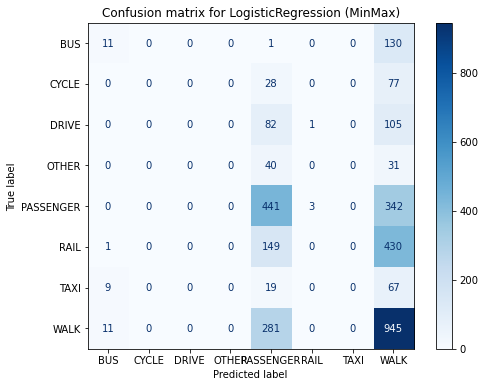

============== Feature importance ============


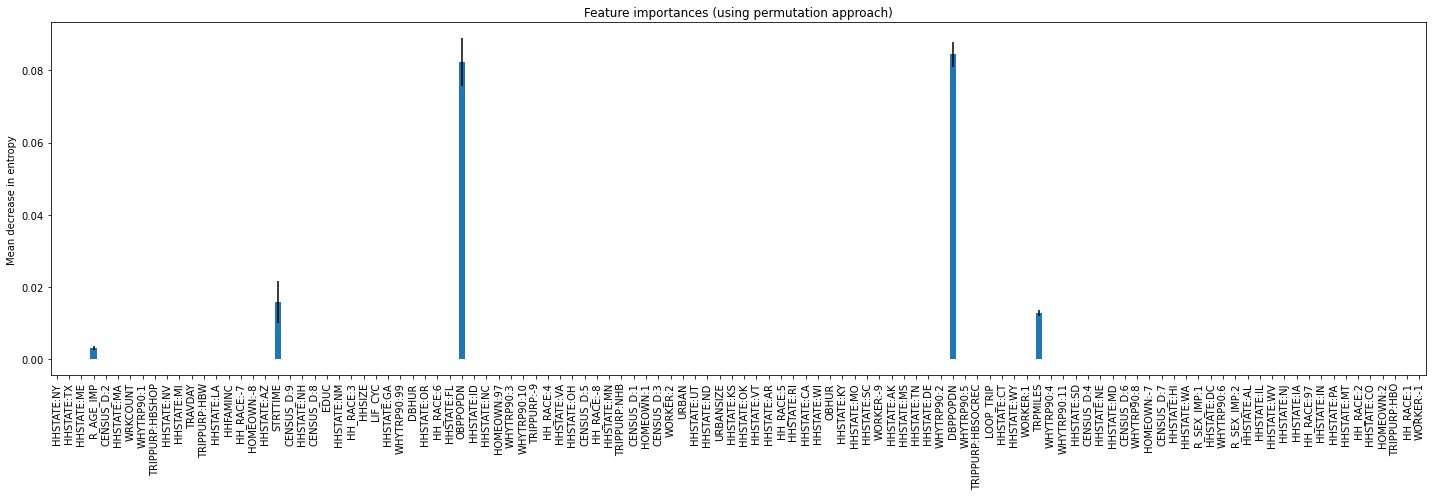

In [34]:
evaluate_model("LogisticRegression (MinMax)", best_logreg, logsearch)

============== Basic metrics ================
Model LogisticRegression (Standard) with parameters:
	C=0.6587806341330127
	class_weight=None
	penalty=l1
Evaluated on validation dataset got scores of 
	cross-entropy loss: 1.5188039281118273
	          accuracy: 0.4360174781523096
============== Confusion matrix ==============


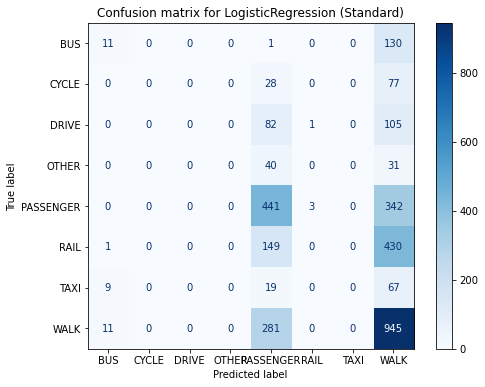

============== Feature importance ============


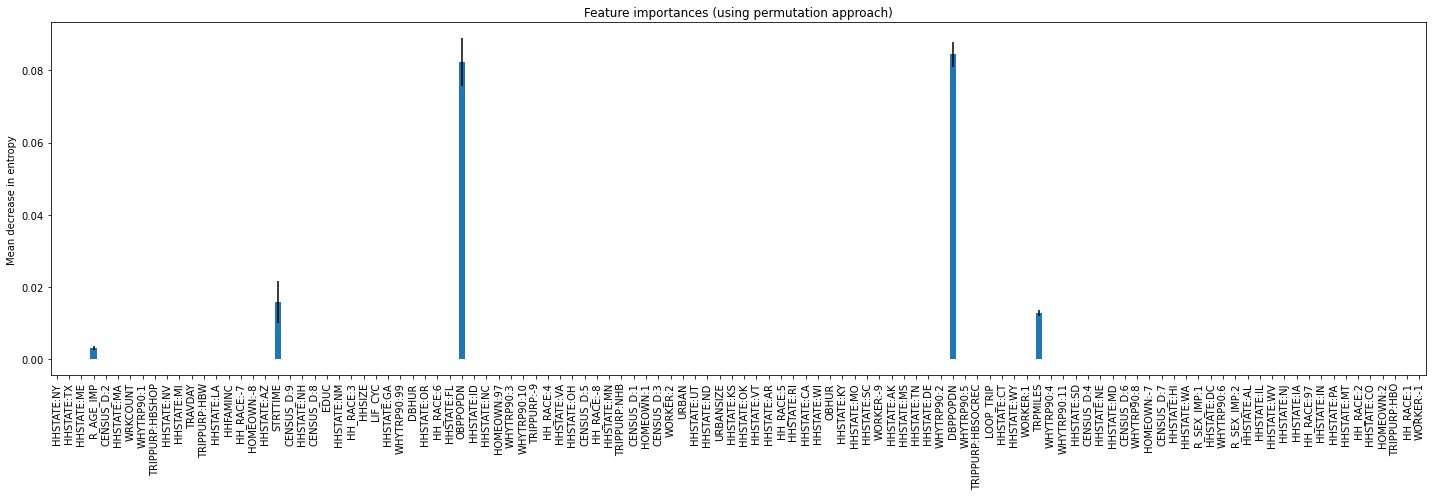

In [35]:
evaluate_model("LogisticRegression (Standard)", best_logreg_std, logstdsearch)

## Step 4: Final prediction

In [36]:
def generate_prediction(name, model, X=X_unsplit, y=y_unsplit, X_test=X_test):
    fresh_model = clone(model).fit(X, y)
    y_pred = fresh_model.predict_proba(X_test)
    
    pd.DataFrame(y_pred, columns=target_encoding.keys(), index=X_test.index).to_csv(f"best_{name}_pred.csv")


In [37]:
generate_prediction("xgb", best_xgb)

In [38]:
generate_prediction("rf", best_rf)

In [39]:
generate_prediction("llmm", best_logreg)

C:\Users\Luca\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [40]:
generate_prediction("llstd", best_logreg_std)

C:\Users\Luca\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
